# Exercises

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

##### Import the data form data/moving_lfp.pickle (the file is already on your machine if you run the download_data() cell in the main lesson)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf
import timeit

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})

In [17]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/7BosHgemAseANIc')

with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp'][0:3000]
#print(lfp)

sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 3.0 seconds of LFP, sampled at 1000.0 Hz


###### Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal. Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
When we adjust the width of the bandpass filter while keeping the central frequency fixed, we observe that the plotted data shows a broader (or narrower, depending on the adjustment) frequency spectrum within the total range of 0-200 Hz. Increasing the width allows more of the original signal to be displayed. For instance, I narrowed the frequency range for the "theta" plot and widened it for the "fast gamma" plot. In the "fast gamma" plot, we can observe that the signal closely resembles the original.

Alternatively, when we alter the central frequency while maintaining the width of the frequency band, we shift the frequency representation either towards higher or lower frequencies in the signal. This adjustment is demonstrated in the "slow gamma" plot.

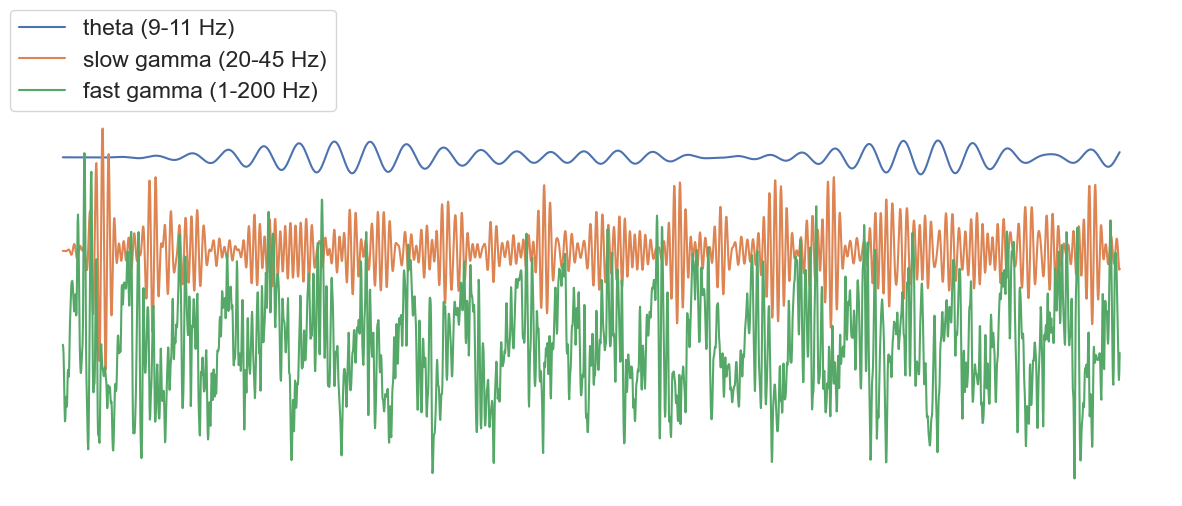

In [18]:
#width of the centre changes
theta_lfp = lf.bandpass_filter(lfp,low_f=9,high_f=11, sampling_rate=sampling_rate)
slow_gamma_lfp = lf.bandpass_filter(lfp,low_f=45,high_f=70, sampling_rate=sampling_rate)
fast_gamma_lfp = lf.bandpass_filter(lfp,low_f=1,high_f=200, sampling_rate=sampling_rate)

plot_offset = 200 #to plot the signal on different lines

plt.figure(figsize=(15,5))
plt.plot(theta_lfp[:3000]+2*plot_offset,label='theta (9-11 Hz)')
plt.plot(slow_gamma_lfp[:3000]+plot_offset,label = 'slow gamma (20-45 Hz)')
plt.plot(fast_gamma_lfp[:3000],label = 'fast gamma (1-200 Hz)')

plt.axis('off')
plt.legend(loc=(0,1))


##### Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command %timeit )
As the filter order increases, the filtered signal tends to lean more towards negative voltages, while the positive voltages become less prominent. This observation aligns with Figure 3 in the "Local-field-potential" explanation document, which illustrates the frequency transfer function of a low-pass Butterworth filter with a cutoff frequency of 1. Notably, observe the logarithmic scale on the x-axis. Here, it becomes apparent that as the order increases, frequencies beyond the cutoff frequency experience a sharper decrease in amplitude. Additionally, the amplitude diminishes towards the negative region, elucidating why the signal's amplitude appears to shift towards more negative values.
Regarding computation times, there is a gradual increase as the filter order rises, as evidenced by the following sequence: [0.0006758000000104403, 0.0015319999999974243, 0.002395999999976084, 0.003642200000001594, 0.0039638000000081774, 0.002907999999990807]. However, there is an exception with the 5th order, where the time decreases again.

Computing times: [0.00024399999529123306, 0.0005577000047196634, 0.0007706000033067539, 0.000923699997656513, 0.001040299997839611, 0.0012344999995548278]


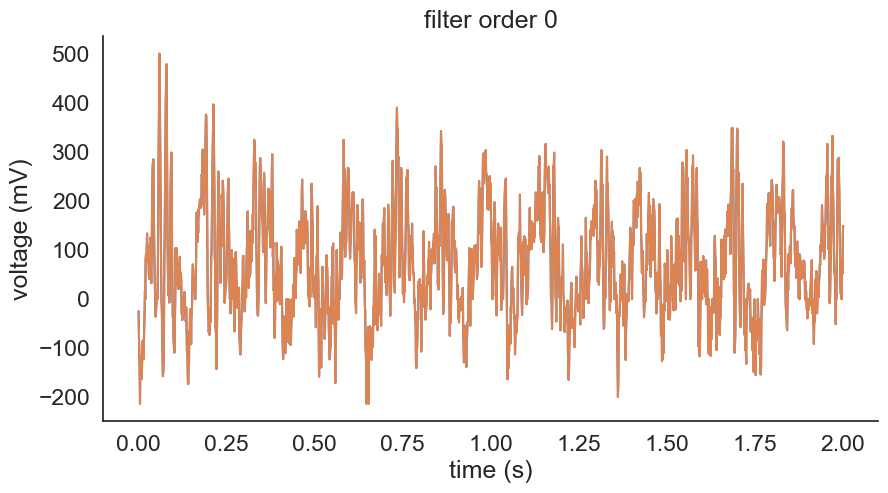

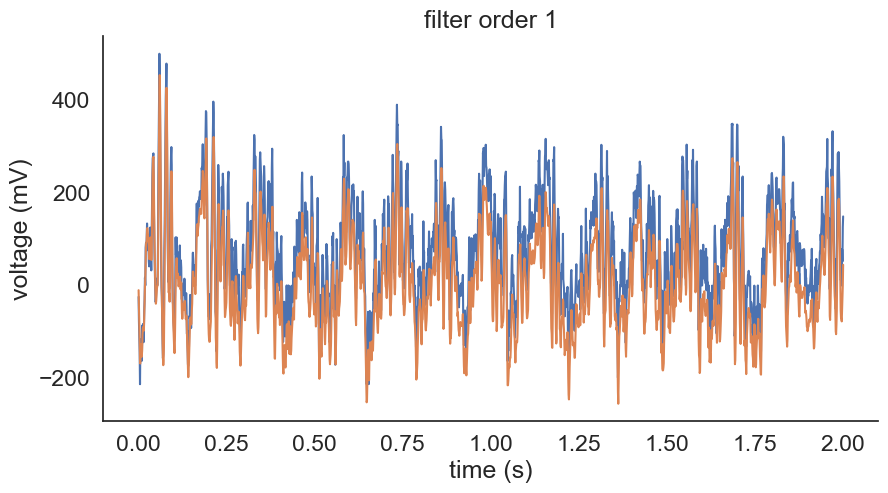

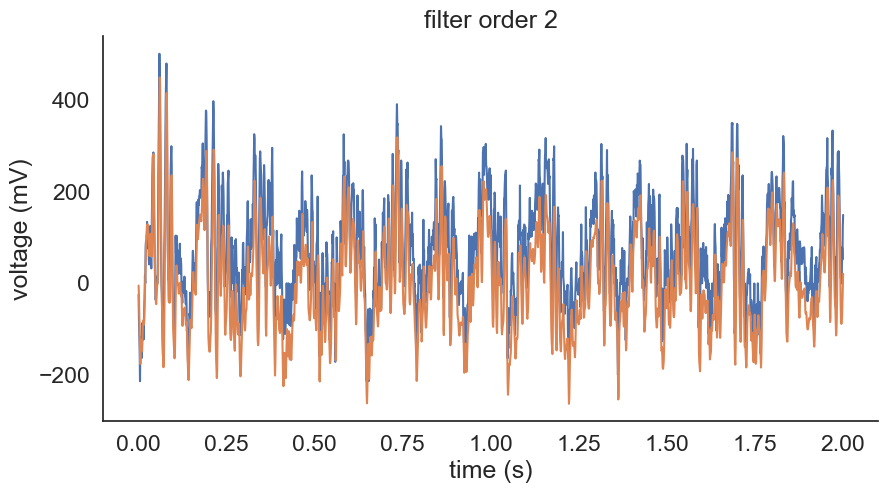

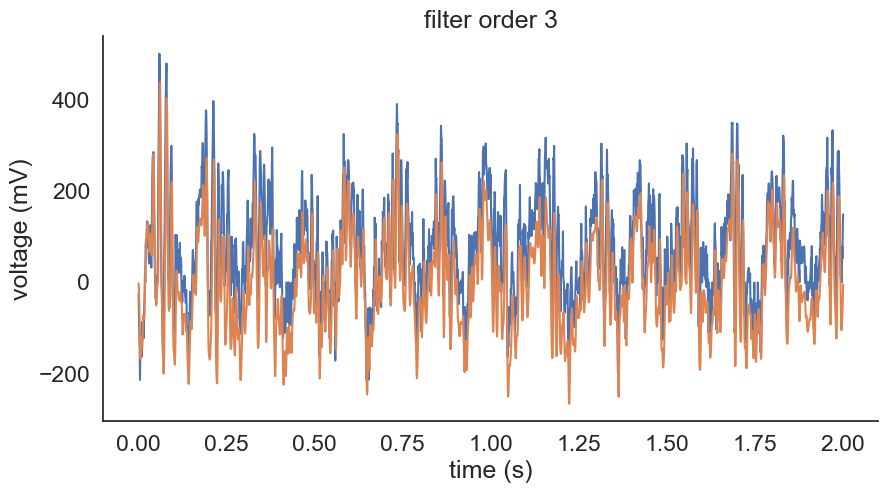

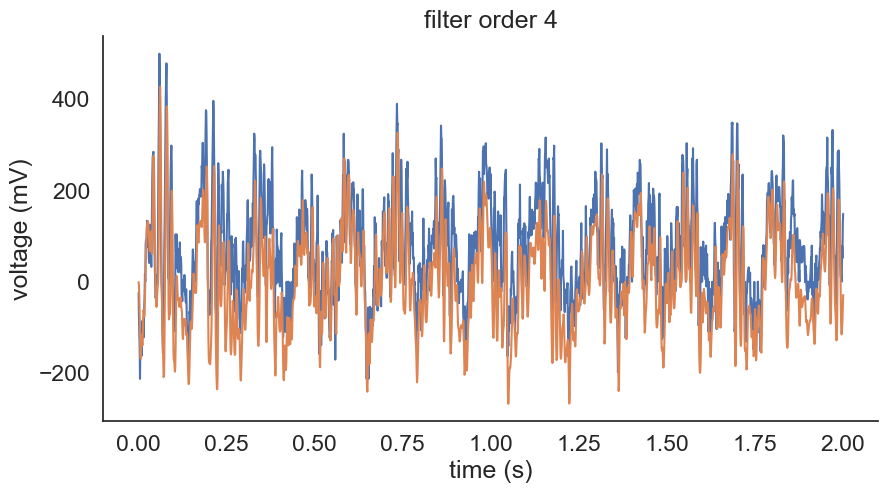

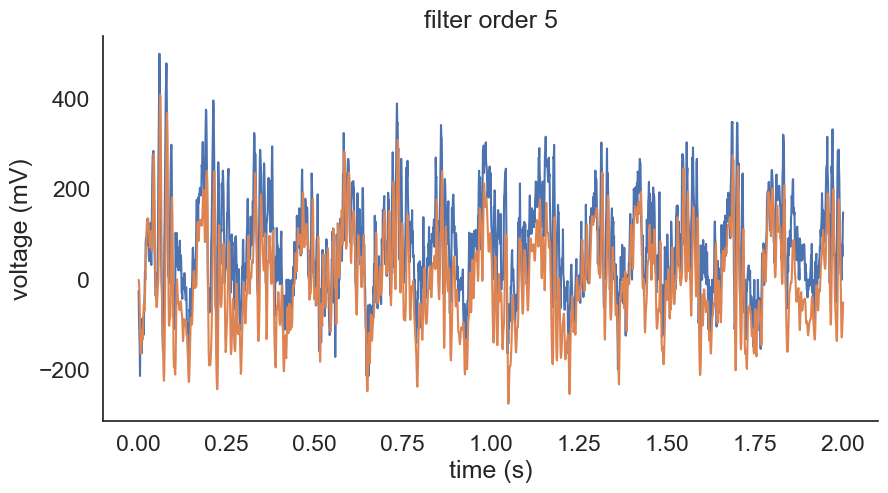

In [19]:
import timeit
from scipy.signal import butter
from scipy.signal import sosfilt
from utils import download_data
import pickle
low_f = 1
high_f = 200
download_data('https://surfdrive.surf.nl/files/index.php/s/7BosHgemAseANIc')

with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']


computing_times = []

for i in range(6):

    filter_order = i #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability
    

    setup_code = '''
import timeit
from scipy.signal import butter
from scipy.signal import sosfilt
from utils import download_data
import pickle
low_f = 1
high_f = 200
download_data('https://surfdrive.surf.nl/files/index.php/s/7BosHgemAseANIc')

with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']'''
    
    #define filter object
    timed_code = f'''
filter = butter({filter_order},[low_f,high_f],
                    btype='band', 
                    output='sos', 
                    fs=sampling_rate)'''
    
    computing_time = timeit.timeit(timed_code, setup_code, number=1)            
    computing_times.append(computing_time)
    
    #define filter object
    filter = butter(filter_order,[low_f,high_f],
                btype='band', 
                output='sos', 
                fs=sampling_rate)
    
    #apply filter to lfp       
    wideband_lfp = sosfilt(filter, lfp)

    plt.figure(figsize=(10,5))
    plt.plot(np.linspace(0,2,2000),lfp[:2000],label='raw signal')
    plt.plot(np.linspace(0,2,2000),wideband_lfp[:2000],label = 'wideband filtered')
    plt.xlabel('time (s)')
    plt.ylabel('voltage (mV)')
    plt.title(f'filter order {filter_order}')
    
print("Computing times:", computing_times)    

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). These are all real wavelets.
- What differences do you see with respect to the spectrum computed with the complex Morlet tranform ? Comment on why do you think this might be the case.

##### Select a period of a few seconds of the signal and compute the spectrogram. Try the wavelet transform with wavelet mexh (mexican hat),gaus (gaussian) and morl (morlet). These are all real wavelets.

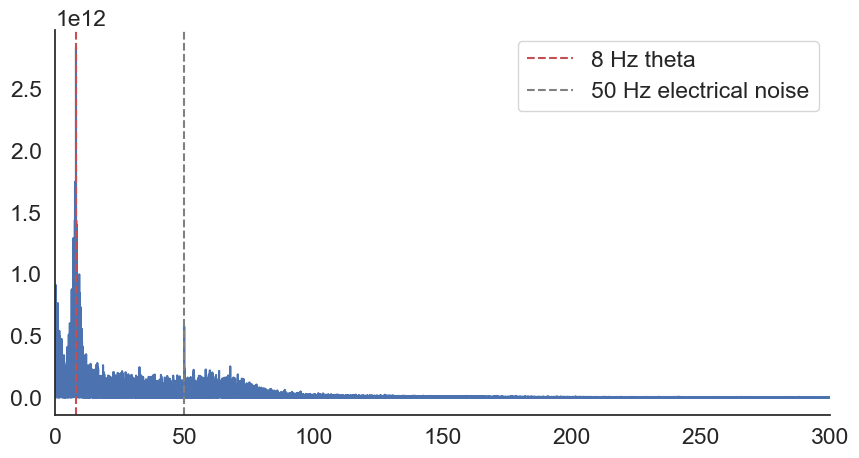

In [20]:
from scipy.fft import fft, fftfreq

n_samples = len(lfp)
sample_dt = 1. / sampling_rate

# we subtract the mean to get rid of the 0 frequency component in the spectrum
centered_lfp = lfp - np.mean(lfp)

transformed_signal = fft(centered_lfp) 

frequencies = fftfreq(n_samples,sample_dt) 

transformed_signal = transformed_signal[:n_samples//2]
frequencies = frequencies[:n_samples//2]

power = abs(transformed_signal)**2

plt.figure(figsize = (10,5))
plt.plot(frequencies,power)
#plt.ylim([0, 10])
plt.xlim([0,300]) # restrict to 
plt.axvline(x=8 ,c='r',linestyle='--',label='8 Hz theta')
plt.axvline(x=50 ,c='grey',linestyle='--',label='50 Hz electrical noise')

plt.legend()

In [21]:
from ipywidgets import interact
import ipywidgets as widgets
from scipy import signal
from pywt import scale2frequency
from pywt import cwt

def plot_wavelet_morlet(scale,freq):
    plt.figure(figsize=(10,5))
    wavelet = signal.morlet(1000,s=scale,w=freq)
    envelope = abs(wavelet)
    plt.plot(wavelet.real,label='wavelet (real part)')
    plt.plot(envelope, label = 'envelope')
    plt.legend(loc=[1,1])
    plt.axis('off')

interact(plot_wavelet_morlet, scale = widgets.FloatSlider(min=.05, max=2, value=.5),
                       freq = widgets.FloatSlider(min=1, max=20, value=5))

def plot_wavelet_mexican_hat(scale,freq):
    plt.figure(figsize=(10,5))
    wavelet = signal.ricker(100, 4)
    envelope = abs(wavelet)
    plt.plot(wavelet.real,label='wavelet (real part)')
    plt.plot(envelope, label = 'envelope')
    plt.legend(loc=[1,1])
    plt.axis('off')

interact(plot_wavelet_mexican_hat, scale = widgets.FloatSlider(min=.05, max=2, value=.5),
                       freq = widgets.FloatSlider(min=1, max=200, value=5))

t= np.linspace(-1, 1, 200, endpoint=False)

def plot_wavelet_gaussian(scale,freq):
    plt.figure(figsize=(10,5))
    wavelet = signal.gausspulse(t, fc=4,)
    envelope = abs(wavelet)
    plt.plot(wavelet.real,label='wavelet (real part)')
    plt.plot(envelope, label = 'envelope')
    plt.legend(loc=[1,1])
    plt.axis('off')

interact(plot_wavelet_gaussian, scale = widgets.FloatSlider(min=.05, max=2, value=.5),
                       freq = widgets.FloatSlider(min=1, max=20, value=5))


interactive(children=(FloatSlider(value=0.5, description='scale', max=2.0, min=0.05), FloatSlider(value=5.0, d…

interactive(children=(FloatSlider(value=0.5, description='scale', max=2.0, min=0.05), FloatSlider(value=5.0, d…

interactive(children=(FloatSlider(value=0.5, description='scale', max=2.0, min=0.05), FloatSlider(value=5.0, d…

<function __main__.plot_wavelet_gaussian(scale, freq)>

Text(0.5, 1.0, 'Convolution with (complex) morlet transform')

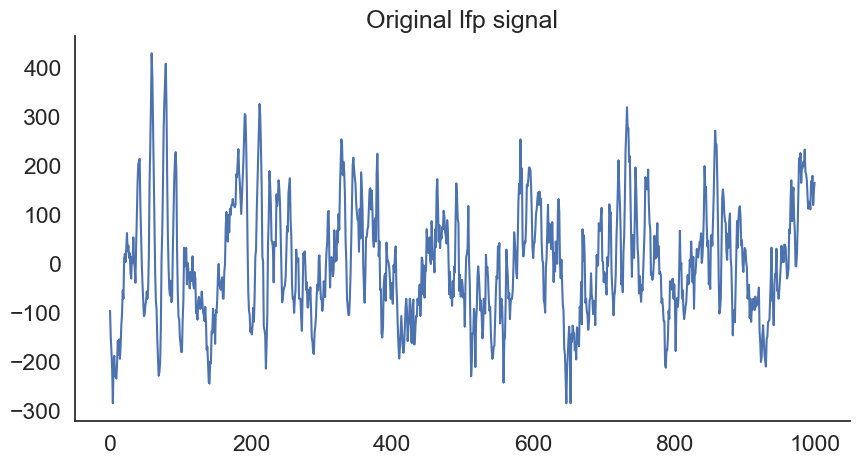

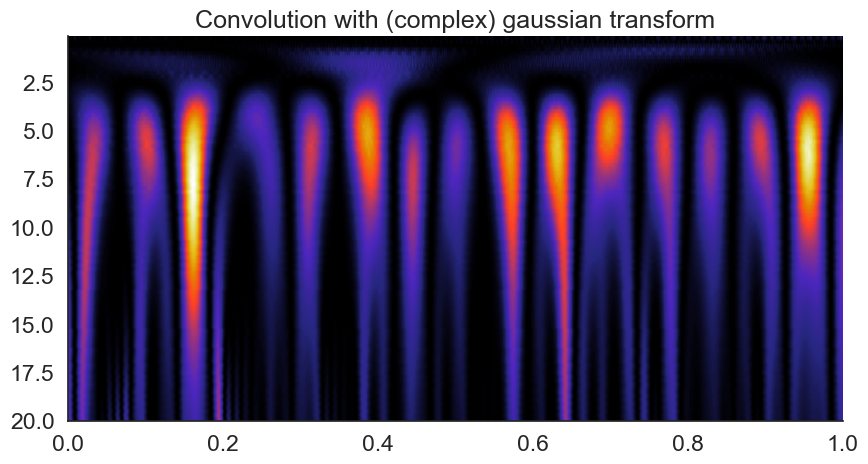

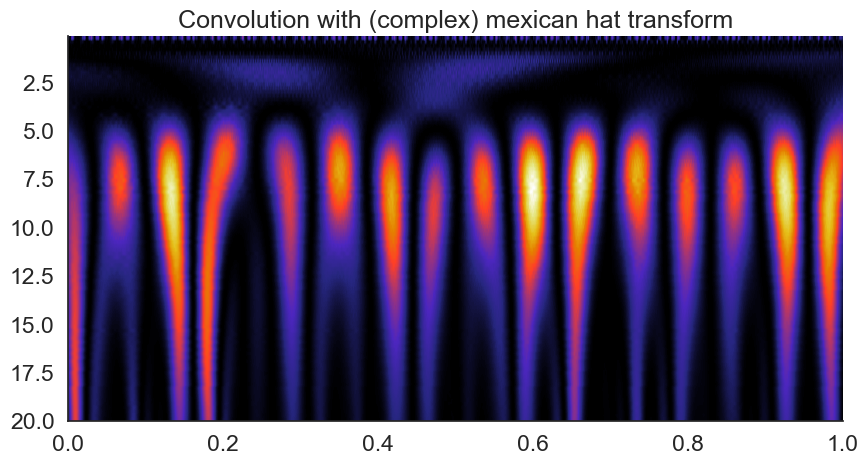

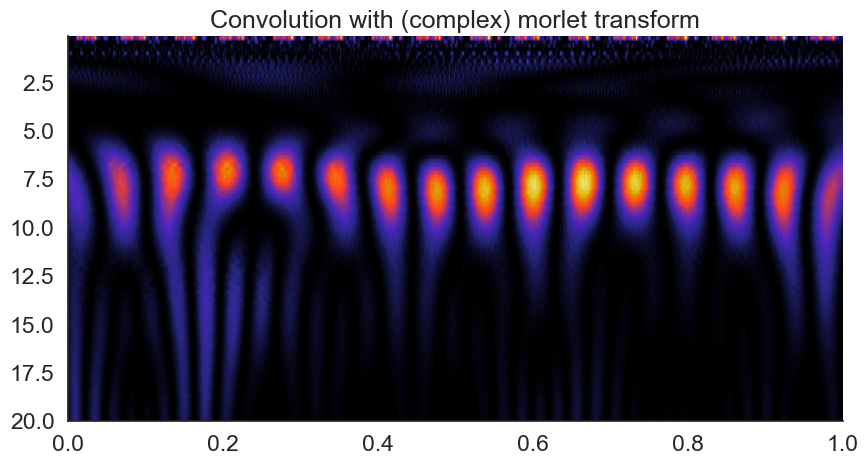

In [22]:
from pywt import wavelist
from pywt import scale2frequency
from pywt import cwt

start = 0 
end = 1 

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

plt.figure(figsize=(10,5))
plt.plot(sig)
plt.title('Original lfp signal')

#morlet

frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet = 'gaus1'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')
plt.title('Convolution with (complex) gaussian transform')

wavelet = 'mexh'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')
plt.title('Convolution with (complex) mexican hat transform')

wavelet = 'morl'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')
plt.title('Convolution with (complex) morlet transform')


##### What differences do you see with respect to the spectrum computed with the complex Morlet tranform? Comment on why do you think this might be the case.
Each transform—Mexican hat, Gaussian, and Morlet—exhibits distinct real parts, as evident in the provided code displaying their envelopes. Consequently, the convolution of each of these transforms will reflect the characteristics of their enveloped real parts. As a result, the Gaussian transform produces a broad convolved area, represented by a wider range of the orange bulbs, corresponding to the frequencies of interest. In contrast, the Mexican hat transform showcases more pronounced activity on the sides due to the shape of its real part function. Lastly, the Morlet transform predominantly highlights the central area associated with the frequencies of interest.

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/moving_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.

##### Download the data.

In [23]:
download_data('https://surfdrive.surf.nl/files/index.php/s/7BosHgemAseANIc')

with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']

##### Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.

Text(0.5, 1.0, 'Instantaneous power for Theta waves')

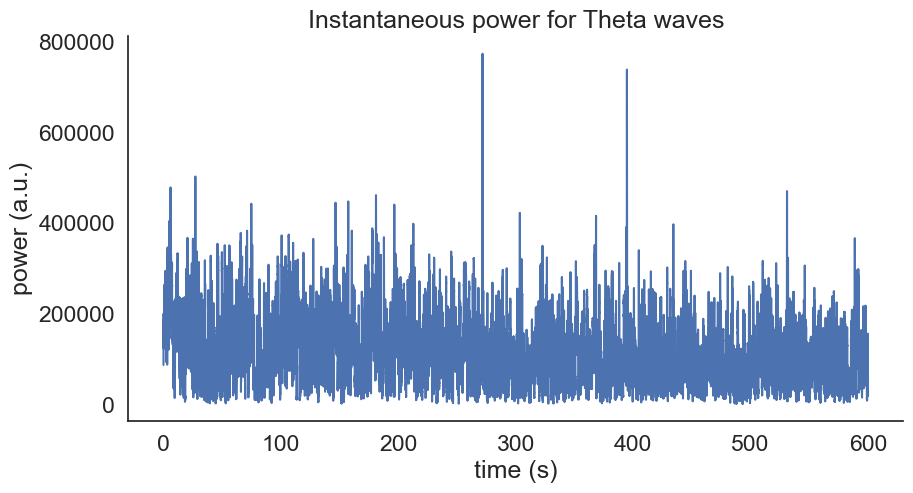

In [24]:
from scipy.stats import zscore

start = 0 
end = 600.133 

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

frequencies =  np.linspace(6,10,50)/sampling_rate
wavelet = 'cmor1.0-1.0'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)

power_theta = np.mean(abs(cwtmatr)**2,axis=0)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(power_theta)),power_theta)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')
plt.title('Instantaneous power for Theta waves')

Z scores of theta power function [-0.1960441  -0.1924039  -0.19830499 ... -0.18554401 -0.18620291
 -0.18197734]


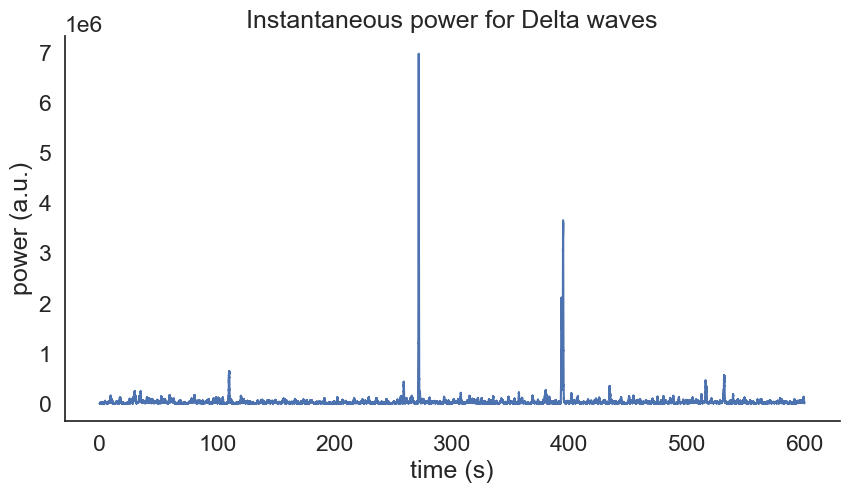

In [25]:
start = 0 
end = 600.133 

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

frequencies =  np.linspace(2,4,50)/sampling_rate
wavelet = 'cmor1.0-1.0'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)

power_delta = np.mean(abs(cwtmatr)**2,axis=0)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(power_delta)),power_delta)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')
plt.title('Instantaneous power for Delta waves')

z_score_theta = zscore(power_delta)
print(f'Z scores of theta power function {z_score_theta}')

##### Z-score the two power signals (subtract the mean and divide by the standard deviation, you can use scipy.stats.zscore())

In [26]:
z_s_theta = zscore(power_theta)
print(f'Z scores of theta power function {z_s_theta}')


z_s_delta = zscore(power_delta)
print(f'Z scores of delta power function {z_s_delta}')

Z scores of theta power function [-0.35747059 -0.32734339 -0.31389373 ... -1.26148669 -1.27406238
 -1.27256483]
Z scores of delta power function [-0.1960441  -0.1924039  -0.19830499 ... -0.18554401 -0.18620291
 -0.18197734]


##### Compute and plot the power difference (theta_power - delta_power) for the sleep session.

Text(0.5, 1.0, 'Power difference between Theta and Delta waves')

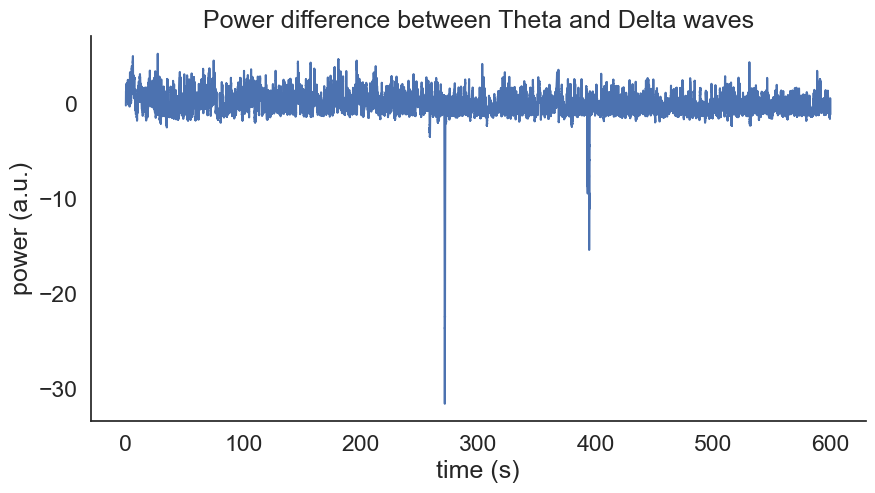

In [27]:
power_diff = z_s_theta - z_s_delta

plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(power_diff)),power_diff)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')
plt.title('Power difference between Theta and Delta waves')

##### Compute the REM (power difference >0.2) and nREM (power diffewrence <0.2) sleep periods.

In [30]:
power_diff_b = power_diff[power_diff >= 0.2]

power_diff_s = power_diff[power_diff <= 0.2]

##### Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).

Text(0.5, 1.0, 'nREM lfp signals')

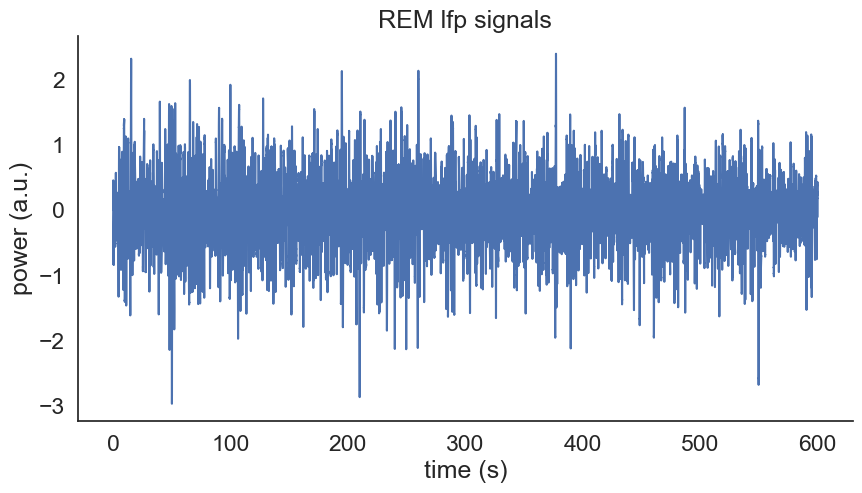

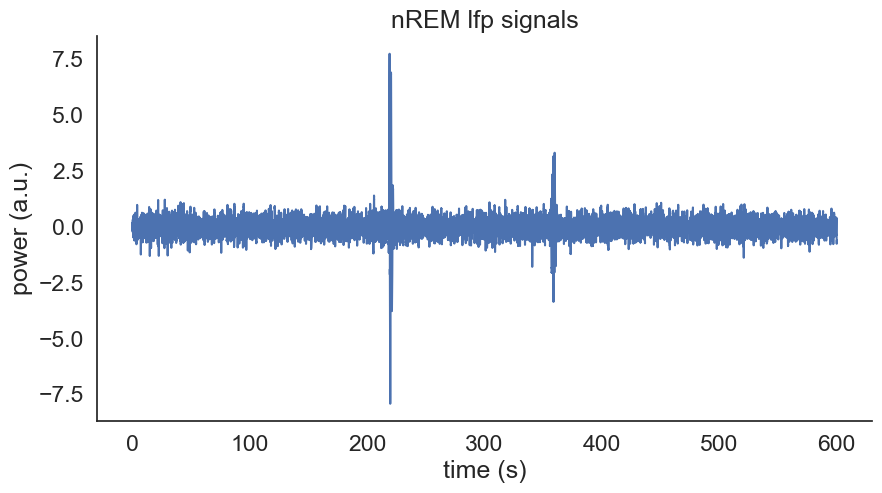

In [31]:
filter_order = 5 #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability
low_f = 1
high_f = 200

filter = butter(filter_order,[low_f,high_f],
                btype='band', 
                output='sos', 
                fs=sampling_rate)
                
#apply filter to lfp       
wb_lfp_b = sosfilt(filter, power_diff_b)
wb_lfp_s = sosfilt(filter, power_diff_s)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(wb_lfp_b)),wb_lfp_b,label = 'wideband filtered')
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')
plt.title('REM lfp signals')

plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(wb_lfp_s)),wb_lfp_s)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')
plt.title('nREM lfp signals')

##### Explore how changing the threshold affects the amount of REM sleep detected.
Increasing the threshold for the power difference reduces the power of the REM signals.

-0.11869366483431058
-5.107196479738271e-16


Text(0.5, 1.0, 'REM lfp signals')

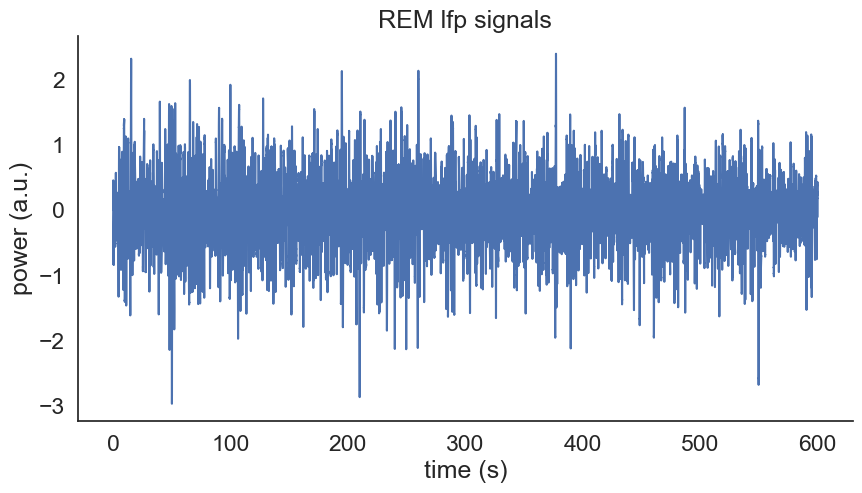

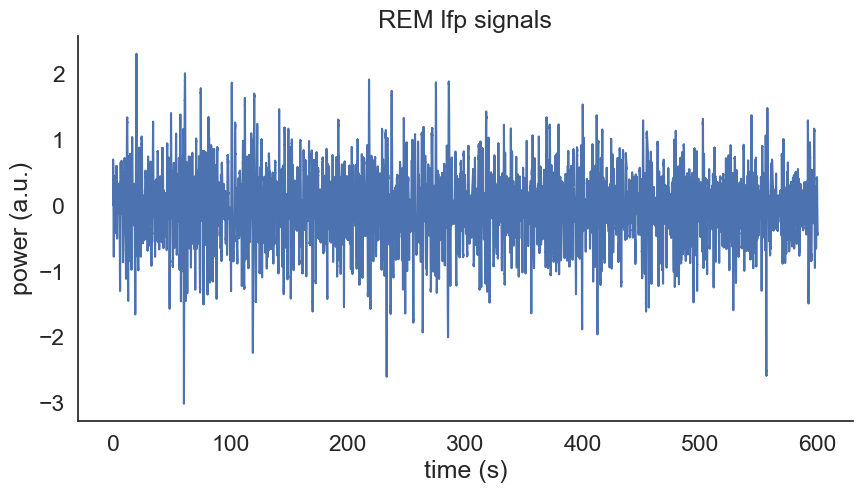

In [32]:
mean_power_diff = np.mean(power_diff)
median_power_diff = np.median(power_diff)
print(median_power_diff)
print(mean_power_diff)

power_diff_b_og = power_diff[power_diff >= 0.2]
power_diff_b = power_diff[power_diff >= 0.6]

filter_order = 5 #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability
low_f = 1
high_f = 200

filter = butter(filter_order,[low_f,high_f],
                btype='band', 
                output='sos', 
                fs=sampling_rate)
                
#apply filter to lfp       
wb_lfp_b_og = sosfilt(filter, power_diff_b_og)
wb_lfp_b = sosfilt(filter, power_diff_b)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(wb_lfp_b_og)),wb_lfp_b_og,label = 'wideband filtered')
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')
plt.title('REM lfp signals')

plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(wb_lfp_b)),wb_lfp_b,label = 'wideband filtered')
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')
plt.title('REM lfp signals')